## Playing around with some spatial data

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd; 
import geopandas as gp
from shapely.geometry import Point, Polygon, MultiPolygon, LineString, MultiLineString
import numpy as np
import sys
import os
import contextily as ctx

# helper functions
sys.path.insert(0, 'helper_functions/')
from logger_settings import logger
from wfs_processing import get_available_layers_from_wfs, get_layer_from_wfs
pd.set_option('display.max_columns', 100)

# data downloaded from http://insideairbnb.com/get-the-data.html
PATH_TO_DATA = '/home/diederik/ams/pyprojects/geospatial_analysis/data/'
AIR_BNB_FILE = 'airbnb_ams_listings_summary.csv' # summary version

# ams gebieden from WFS (). For full services see: https://api.data.amsterdam.nl/api/
url_wfs = 'https://map.data.amsterdam.nl/maps/gebieden'

In [3]:
# see what layers are available
get_available_layers_from_wfs(url_wfs=url_wfs)

Sun, 05 Aug 2018 22:06:46 INFO     layername: buurt
Sun, 05 Aug 2018 22:06:46 INFO     layername: buurt_simple
Sun, 05 Aug 2018 22:06:46 INFO     layername: buurtcombinatie
Sun, 05 Aug 2018 22:06:46 INFO     layername: buurtcombinatie_simple
Sun, 05 Aug 2018 22:06:46 INFO     layername: gebiedsgerichtwerken
Sun, 05 Aug 2018 22:06:46 INFO     layername: stadsdeel
Sun, 05 Aug 2018 22:06:46 INFO     layername: bouwblok
Sun, 05 Aug 2018 22:06:46 INFO     layername: grootstedelijkgebied
Sun, 05 Aug 2018 22:06:46 INFO     layername: unesco
Sun, 05 Aug 2018 22:06:46 INFO     layername: buurt_label
Sun, 05 Aug 2018 22:06:46 INFO     layername: buurtcombinatie_label
Sun, 05 Aug 2018 22:06:46 INFO     layername: gebiedsgerichtwerken_label
Sun, 05 Aug 2018 22:06:46 INFO     layername: stadsdeel_label
Sun, 05 Aug 2018 22:06:46 INFO     layername: bouwblok_label
Sun, 05 Aug 2018 22:06:46 INFO     layername: grootstedelijkgebied_label
Sun, 05 Aug 2018 22:06:46 INFO     layername: unesco_label


['buurt',
 'buurt_simple',
 'buurtcombinatie',
 'buurtcombinatie_simple',
 'gebiedsgerichtwerken',
 'stadsdeel',
 'bouwblok',
 'grootstedelijkgebied',
 'unesco',
 'buurt_label',
 'buurtcombinatie_label',
 'gebiedsgerichtwerken_label',
 'stadsdeel_label',
 'bouwblok_label',
 'grootstedelijkgebied_label',
 'unesco_label']

In [162]:
# load wfs layer , choise a layer
sd = get_layer_from_wfs(url_wfs=url_wfs, layer_name='stadsdeel', 
                        crs=28992, outputformat='geojson')

Sun, 05 Aug 2018 23:52:58 INFO     Requesting data from https://map.data.amsterdam.nl/maps/gebieden, layer: stadsdeel
Sun, 05 Aug 2018 23:52:58 INFO     8 features returned.


In [163]:
cols_to_keep = ['code','display', 'geometry', 'id', 'naam']
crs = {'init': 'epsg:28992'}
sd = gp.GeoDataFrame.from_features(sd['features'], crs = crs)[cols_to_keep]

In [46]:
# load airbnb data
date_cols = ['last_review']
df= (pd.read_csv(PATH_TO_DATA + AIR_BNB_FILE, parse_dates=date_cols, decimal = ',')
    .dropna(how= 'all', axis=1))

df['price'] = df['price'].astype(float) 

df = df.rename(columns = {'longitude': 'lon', 'latitude': 'lat'})
# lon, lat to float
for col in ['lon', 'lat']:
    df[col] = df[col].astype(float)

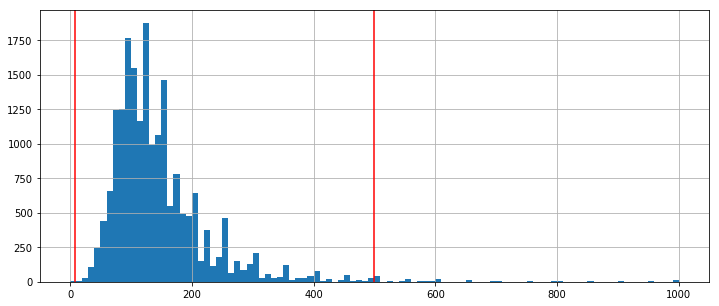

In [53]:
_, bins = pd.qcut(df['price'], q=[0.0001, 0.99], retbins=True)
ax = df['price'].hist(bins=100, range=(0,1000), figsize= [12,5])

for b in bins:
    ax.axvline(b, color='r')

In [54]:
# skim off the extreme prices (bins = array([ -10.,  455.]))
df = df[(df['price'] > bins[0]) & (df['price'] < bins[1])]

In [55]:
crs_initial = {'init': 'epsg:4326'} 
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
df = gp.GeoDataFrame(df, crs=crs_initial, geometry=geometry)
df = df.drop(['lon', 'lat'], axis=1)

In [56]:
# change to RD new Amersfoort
crs = {'init': 'epsg:28992'}
df = df.to_crs(crs=crs)

In [57]:
df.head(1)

,id,name,host_id,host_name,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,Private room,69.0,3,233,2018-06-24,2.06,1,116,POINT (124637.2554813915 486523.2381693435)


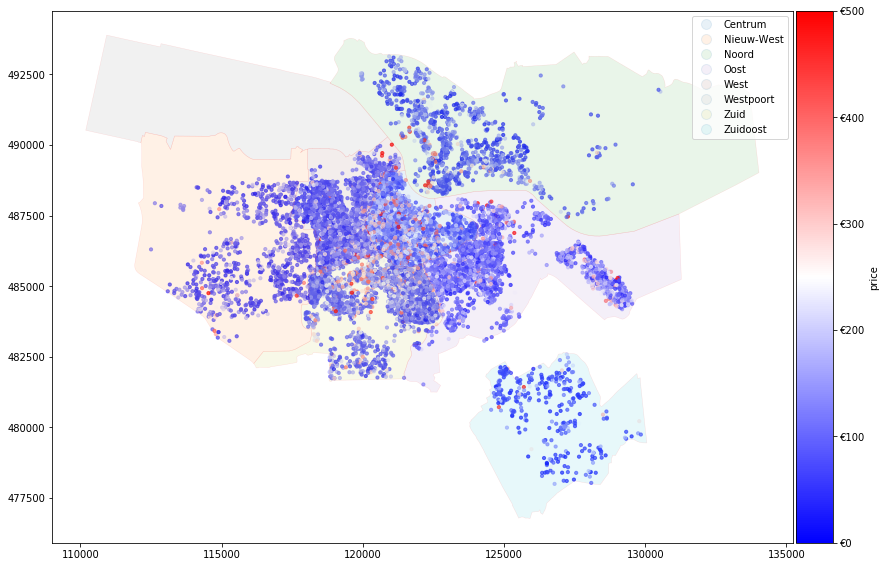

In [173]:
# hell of a job to get the adjusted colorbar size (Argghh)
from mpl_toolkits.axes_grid1 import make_axes_locatable
style_kwds = {'markersize': 10, 'alpha': .7}
vmin, vmax = 0, 500

fig, ax= plt.subplots(figsize=[14,14])
ax = df.plot(column='price', ax=ax, cmap='bwr', **style_kwds)

sm = plt.cm.ScalarMappable(cmap='bwr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
# fake up the array of the scalar mappable. 
sm._A = []
plt.colorbar(sm, cax, label='price')
# adjust colorbar tick formatting
cb = ax.get_figure().get_axes()[1]
cb.set_yticklabels(['€{0:.0f}'.format(ytick) for ytick in yticks]);

style_kwd_sd = {'alpha': .1, 'linewidth': .5, 'edgecolor': 'red'}
sd.plot(ax=ax, **style_kwd_sd, column='naam', legend=True)

In [165]:
sd

,code,display,geometry,id,naam
0,B,Westpoort,"POLYGON ((115438.2551681 489780.5773693, 11543...",03630000000020,Westpoort
1,M,Oost,"POLYGON ((123334.2436606 486309.3116985, 12340...",03630011872039,Oost
2,N,Noord,"POLYGON ((126867.5316472 487456.3432995, 12661...",03630000000019,Noord
3,A,Centrum,"POLYGON ((120535.889057 486273.4893039, 120528...",03630000000018,Centrum
4,E,West,"POLYGON ((118423.4169138 485693.1108398, 11840...",03630011872036,West
5,F,Nieuw-West,"POLYGON ((118044.319122 485048.0111144, 118095...",03630011872037,Nieuw-West
6,K,Zuid,"POLYGON ((118669.4043669 485703.1518227, 11872...",03630011872038,Zuid
7,T,Zuidoost,"POLYGON ((129103.242 479278.077, 129090.573 47...",03630000000016,Zuidoost


The Airbnb contains neighboordhood names that don't seem proper. Let's use the offical names  of the 'stadsdelen', 'wijken' and 'buurten' of the municipality of amsterdam as offered in their WFS geojsons. We merge the data back on the dataframe with spatial joins (intersect)

In [172]:
# add the stadsdelen
df = gp.sjoin(df, sd[['geometry', 'code', 'naam']], how='inner', op='intersects')

In [ ]:
# airbnb change